## CSE595 Homework 1 : Logistic Regression Implementation

In [331]:
import pandas
import re
from collections import Counter
import numpy as np
from scipy import sparse
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [4]:
%pip install torch
%pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [224]:
# Function to load stop words from NLTK Github Repo to be removed
def load_stopwords():
    f = open("stopwords.txt")
    words = f.readlines()
    stopwords = set()
    for i in words:
        i = i.strip()
        stopwords.add(i)
    return stopwords

stopwords = load_stopwords()

### Part 1 : Representing Text Data

In [225]:
# tokenizes purely by using whitespace
def tokenize (sentence : str):
    tokens = sentence.split()
    return tokens

In [226]:
# tokenizing by ignoring capitalization, removing stop words as well as all punctuations
def better_tokenize(text : str):
    # store unique tokens in tokens
    tokens = []
    # convert entire text into lowercase
    lowercase = text.lower()
    # find all possible words and all possible punctuations as their own tokens
    words = re.findall(r"\w+|[,.!?#\r\n$%;:()\"']", lowercase)

    for word in words:
        if word not in stopwords:
            tokens.append(word)
    return tokens

In [ ]:
# build the vocabulary with a minimum word frequency of 250 along with a column mapping
def build_vocab(token_docs: list):
    vocab, all_tokens = [], []
    vocab_indices = {}
    for doc in token_docs:
        all_tokens.extend(doc)

    # returns frequences of tokens across all documents
    frequencies = Counter(all_tokens)

    i = 0
    for freq in frequencies:
    #   if above certain threshold, add to vocab
        if frequencies[freq] >= 250:
            vocab.append(freq)
            vocab_indices[freq] = i
            i += 1

    return set(vocab), vocab_indices

# create term document matrix
def create_sparse_matrix(documents : list, tokenizer_func):
    tokenized_docs = []
    for doc in documents:
        tokens = tokenizer_func(doc)
        tokenized_docs.append(tokens)
    vocab, indices = build_vocab(tokenized_docs)

    dense_matrix = []
    for doc in tokenized_docs:
        row = [0] * len(vocab)
        for token in doc:
            if token in vocab:
                row[indices[token]] += 1
        dense_matrix.append(row)

    np_arr = np.array(dense_matrix)
    sparse_td_matrix = sparse.csr_matrix(np_arr)

    return sparse_td_matrix, indices

# create a vector from a singular document of text
def create_document_vector(text, indices, tokenizer_func, numpy=True):
    tokens = tokenizer_func(text)
    # extra feature for bias in the case of numpy though we don't need it for pytorch
    if numpy:
        row = [0] * (len(indices) + 1)
    else:
        row = [0] * (len(indices))
    for token in tokens:
        if token in indices:
            row[indices[token]] += 1
    # one extra feature to account for bias
    row[-1] = 1
    return np.array(row)

# convert boolean dataframe of class labels into numpy array of integers
def create_class_vector(class_labels):
    return np.array(class_labels, dtype=int)


#### Testing Tokenization

In [6]:
df = pandas.read_csv("train.csv")
better_tokenize(df['generation'][0])

['"',
 'conjuring',
 '"',
 'one',
 'thrilling',
 'horror',
 'film',
 'come',
 'recent',
 'times',
 '.',
 '"',
 'sinister',
 '"',
 'one',
 'scariest',
 'films',
 'watched',
 '.',
 'since',
 "'",
 'based',
 '"',
 'true',
 'events',
 '"',
 ',',
 'makes',
 'even',
 'interesting',
 '.',
 "'",
 'quite',
 'give',
 'full',
 '10',
 'star',
 'rating',
 'quite',
 'jump',
 'scares',
 ',',
 'least',
 'good',
 'portion',
 'jump',
 'scares',
 'add',
 'atmosphere',
 'movie',
 '.',
 'first',
 'time',
 'watcher',
 'movie',
 ',',
 'certainly',
 'disturb',
 '.',
 'doesn',
 "'",
 'stick',
 'like',
 '"',
 'sinister',
 '"',
 'long',
 ',',
 'conjuring',
 'fun',
 'watch',
 'always',
 'love',
 'coming',
 'back',
 'rewatch',
 'every',
 '.']

In [7]:
documents_test = ["I like the cat!", "the cat eats.", "i saw this cat and it was adorable i like it so much"]
# matrix, indices = create_sparse_matrix(df["generation"])

print(create_class_vector(df['label'].values))

# print(matrix)
# print(indices)

[0 0 0 ... 1 0 0]


### Part 2 : Logistic Regression w numpy

In [154]:
# Defining sigmoid function that takes in a np array/vector
def sigmoid(x):
    result = 1/(1+np.exp(-x))
    return result

# weights is our beta coefficients, x is the feature vector of a document and y is the ground truth of a document
def log_likelihood(y, predicted_y):
    a = y * predicted_y
    b = np.log(1 + np.exp(predicted_y))
    return a - b

# compute the gradient for a specific x vector, beta coefficients and ground truth y
def compute_gradient(x, y, predicted_y):
    gradient = (sigmoid(predicted_y) - y) * x
    return gradient

In [ ]:
# logistic regression with X matrix each row is a feature vector, Y vector, rate of learning and number of steps
def logistic_regression(X, Y, learning_rate, num_step, epochs = 1, plot=20):
    print(X.shape)
    # Adding a column of ones as bias vector
    bias = np.array([1] * X.shape[0]).reshape(-1, 1)
    sparse_bias = sparse.csr_matrix(bias)
    # horizontally stacking training matrix with bias vector
    X = sparse.hstack([X, sparse_bias], format="csr")

    beta = [0] * X.shape[1]
    # beta values - vector of coefficients initialized to zero
    beta = np.array(beta)

    log_likelihoods = []

    for j in range(epochs):
        for i in range(num_step):
            
            row_ind = random.randint(0, X.shape[0]-1)
            # row_ind = i

            # calculate predicted y using the current coefficient weights
            predicted_y = sparse.csr_matrix.dot(X.getrow(row_ind), beta)

            # compute gradient and update beta vector stochastic gradient descent
            beta = np.subtract(beta, learning_rate * compute_gradient(X.getrow(row_ind), Y[row_ind], predicted_y))
            if i % plot == 0:
                log_likelihoods.append((i+j,log_likelihood(Y[row_ind], predicted_y)[0]))


    return log_likelihoods, beta

def predict(text, beta, indices):
    test_features = create_document_vector(text, indices, better_tokenize)
    predicted_y = np.matmul(test_features, beta)
    return sigmoid(predicted_y) >= 0.5


#### Training the Model

In [ ]:
# setting up term document matrix and class labels as a vector
df = pandas.read_csv("train.csv")

# create a sparse matrix for all training documents
matrix, indices = create_sparse_matrix(df["generation"], better_tokenize)
Y_class = create_class_vector(df['label'].values)

In [157]:
# running the training loop for 1000 steps
learning_rate = 5e-5
num_steps = 1000
log_likelihoods, beta_values = logistic_regression(matrix, Y_class, learning_rate, num_steps)

(55002, 5186)


#### Log likelihood plot for 1000 steps

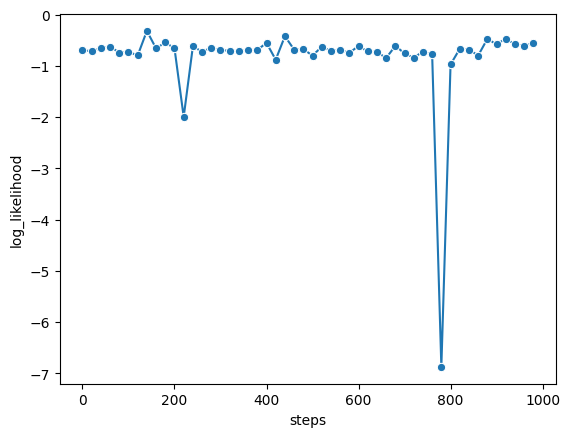

In [158]:
sns.lineplot(data=pandas.DataFrame(log_likelihoods, columns=['steps', 'log_likelihood']), x="steps", y="log_likelihood", marker="o")
plt.show()

(55002, 5186)


C:\Users\nandana\AppData\Local\Temp\ipykernel_29424\3196652572.py:3: RuntimeWarning: overflow encountered in exp
  result = 1/(1+np.exp(-x))


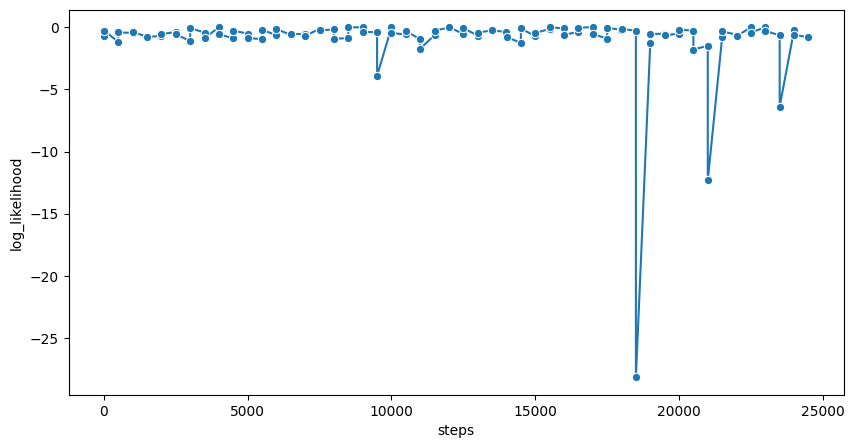

In [203]:
# running the training loop for 1000 steps
learning_rate = 5e-4
num_steps = 25000
log_likelihoods, beta_values = logistic_regression(matrix, Y_class, learning_rate, num_steps, 2, 500)
# print(log_likelihoods)
plt.figure(figsize=(10, 5))

sns.lineplot(data=pandas.DataFrame(log_likelihoods, columns=['steps', 'log_likelihood']), x="steps", y="log_likelihood", marker="o")
plt.show()

#### Validation on Validation Dataset and calculating F-1 score

In [228]:
# Function to calculate F-1 score
def calculate_f1_score(true_pos, false_neg, false_pos):
    precision = true_pos / ((true_pos + false_pos) * 1.0)
    recall = true_pos / ((true_pos + false_neg) * 1.0)
    f1 = (2 * precision * recall ) / ((precision + recall) * 1.0)
    return f1

In [207]:
df_validate = pandas.read_csv("dev.csv")
true_pos, false_pos, false_neg = 0,0,0
Y_class_validate = create_class_vector(df_validate['label'].values)
accurate = 0

for i in range(len(df_validate["generation"])):

    predicted_y = predict(df_validate["generation"].iloc[i], beta_values, indices)
    
    if predicted_y == Y_class_validate[i]:
        accurate += 1
        if predicted_y == 1:
            true_pos += 1
    else:
        if predicted_y == 0:
            false_neg += 1
        else:
            false_pos += 1

print("F1 Score: ", calculate_f1_score(true_pos, false_neg, false_pos))
accuracy = accurate / (len(df_validate) * 1.0)
print("Accuracy: ", accuracy)

F1 Score:  0.7439539347408829
Accuracy:  0.7332


#### Testing the Numpy Model

In [205]:
df_test = pandas.read_csv("test.student.csv")

with open("test_results.txt", "w") as f:
    for i in range(len(df_test["generation"])):
        predicted_y = predict(df_test["generation"].iloc[i], beta_values, indices)
        f.write(f'{df_test["id"].iloc[i]},{predicted_y}\n')

### Part 3 : Logistic Regression w Pytorch

In [282]:
# takes in sparse scipy matrix and converts it into a sparse tensor
def to_sparse_tensor(sparse_scipy):
    # return row and col indices of non zero values along with the values
    row_ind, col_ind, values = sparse.find(sparse_scipy)

    # merge both np arrays to a singular array - this is more efficient 
    indices = np.stack((row_ind, col_ind))
    i = torch.tensor(indices)
    v = torch.tensor(values, dtype=torch.float32)
    return torch.sparse_coo_tensor(i, v)

In [283]:
# Logistic Regression Class extending nn.Module
class LogisticRegression(nn.Module):
    def __init__(self, vocab_size) -> None:
        # call the base class initialization
        super().__init__()
        # singular output feature for binary classification - is it LLM generated or not - predicted_y?
        # input features would be the size of the vocabulary - how many features should we train on?
        self.linear = nn.Linear(in_features = vocab_size, out_features=1)
        self.vocab_size = vocab_size
        self.sigmoid = nn.Sigmoid()

    # forward takes in input sparse matrix - documents with all features
    def forward(self, x):
        # pass the linear layer output into sigmoid function and return the probability
        x = self.linear(x)
        return self.sigmoid(x)

In [ ]:
# setting up term document matrix and class labels as a vector
df = pandas.read_csv("train.csv")

# create a sparse matrix for all training documents
matrix, indices = create_sparse_matrix(df["generation"], better_tokenize)

X_tensor = to_sparse_tensor(matrix)
Y_class = create_class_vector(df['label'].values)

# number of columns of feature vectors
vocab_size = matrix.shape[1]

print(X_tensor.size(), Y_class.shape)

torch.Size([55002, 5186]) (55002,)


In [295]:
model = LogisticRegression(vocab_size)
learning_rate = 5e-5
bce_loss = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

#### Pytorch Training Loop

In [318]:
def train(model, optimizer, X_tensor, Y, num_step, epochs = 1, plot=20,):
    losses = []
    for epoch in range(epochs):  # loop over the dataset multiple times   
        for i in range(num_step):
            row_ind = random.randint(0, X_tensor.size(0)-1)
            inputs = X_tensor[row_ind]
            
            label = torch.tensor([Y[row_ind]], dtype=torch.float32)
            # zero out parameter gradients - they accumulate by default in pytorch
            optimizer.zero_grad()
            # forward pass
            output = model(inputs)
            
            loss = bce_loss(output, label)
            # backward pass
            loss.backward()
            # update parameters with respect to loss
            optimizer.step()

            if i % plot == 0:
                each_loss = loss.item()    
                print(f'[{i}] loss: {each_loss}')
                losses.append((i + epoch,each_loss))
    return losses
    

#### Problem : Training for 1000 steps and plotting Loss

[0] loss: 0.9584570527076721
[50] loss: 0.9057285189628601
[100] loss: 0.32539287209510803
[150] loss: 0.961391031742096
[200] loss: 0.7996078133583069
[250] loss: 0.713042676448822
[300] loss: 0.3061458170413971
[350] loss: 0.44220536947250366
[400] loss: 0.5363704562187195
[450] loss: 0.006945058237761259
[500] loss: 0.4673570692539215
[550] loss: 0.9699648022651672
[600] loss: 0.658214271068573
[650] loss: 0.20070303976535797
[700] loss: 0.42653805017471313
[750] loss: 1.1434566974639893
[800] loss: 0.4212794005870819
[850] loss: 0.6852825880050659
[900] loss: 0.6567081809043884
[950] loss: 0.7686131596565247


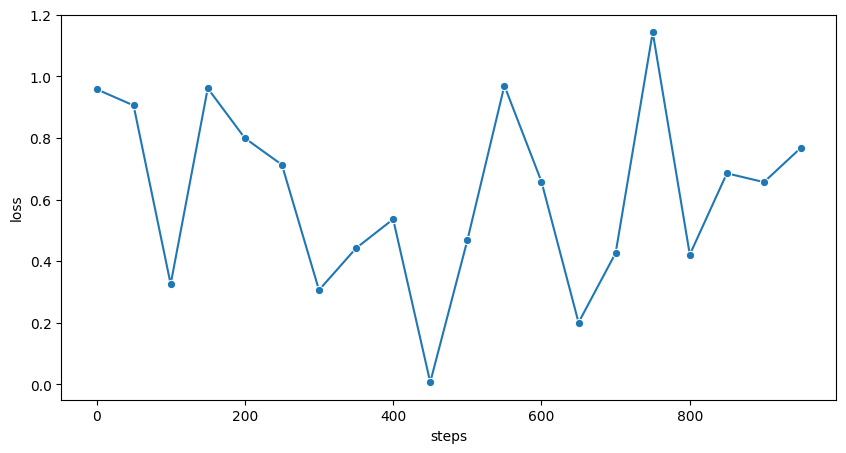

In [ ]:
losses = train(model, optimizer, X_tensor, Y_class, 1000, 1, 50)

plt.figure(figsize=(10, 5))

sns.lineplot(data=pandas.DataFrame(losses, columns=['steps', 'loss']), x="steps", y="loss", marker="o")
plt.show()

In [ ]:
# function that takes in a text and predicts a class label
def predict(text, model, indices, tokenizer):
    test_features = create_document_vector(text, indices, tokenizer, False)
    test_tensor = torch.tensor(test_features, dtype=torch.float32)
    predicted_y = model(test_tensor)
    return predicted_y >= 0.5
    
def evaluate(df_eval, Y_labels, indices, model, tokenizer=better_tokenize):
    true_pos, false_pos, false_neg, accurate = 0,0,0,0
    # this disables certain behaviors
    model.eval()
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for i in range(len(df_eval["generation"])):
            input = df_eval["generation"].iloc[i]
            # predict through the model instantiated
            predicted_y = predict(input, model, indices, tokenizer)

            if predicted_y == Y_labels[i]:
                accurate += 1
                if predicted_y == 1:
                    true_pos += 1
            else:
                if predicted_y == 0:
                    false_neg += 1
                else:
                    false_pos += 1
        print("F1 Score: ", calculate_f1_score(true_pos, false_neg, false_pos))
        accuracy = accurate / (len(df_eval["generation"]) * 1.0)
        print("Accuracy: ", accuracy)

#### Evaluating Pytorch Model

### F1 and Accuracy for 1000 steps Model

In [313]:
# setting up term document matrix and class labels as a vector
df_eval = pandas.read_csv("dev.csv")
Y_class_eval = create_class_vector(df_eval['label'].values)

# number of columns of feature vectors
vocab_size = matrix.shape[1]
evaluate(df_eval, Y_class_eval, indices, model)

F1 Score:  0.6692049272116462
Accuracy:  0.7046


### Weight Decay

In [327]:
learning_rate = 5e-5
bce_loss = nn.BCELoss()

model_def = LogisticRegression(vocab_size)
optimizer_def = torch.optim.SGD(model_def.parameters(), lr=learning_rate)
# 1 full epoch with default weight decay
losses_def = train(model_def, optimizer_def, X_tensor, Y_class, X_tensor.size()[0], 1, 50)

model_001 = LogisticRegression(vocab_size)
optimizer_001 = torch.optim.SGD(model_001.parameters(), lr=learning_rate)
# 1 full epoch with weight decay = .001
losses_001 = train(model_001, optimizer_001, X_tensor, Y_class, X_tensor.size()[0], 1, 50)

model_1 = LogisticRegression(vocab_size)
optimizer_1 = torch.optim.SGD(model_1.parameters(), lr=learning_rate)
# 1 full epoch with weight decay = 0.1
losses_1 = train(model_1, optimizer_1, X_tensor, Y_class, X_tensor.size()[0], 1, 50)

[0] loss: 0.6450409889221191
[50] loss: 0.6566089987754822
[100] loss: 0.7730685472488403
[150] loss: 0.7815772294998169
[200] loss: 0.7620214223861694
[250] loss: 0.9074379205703735
[300] loss: 0.5659297704696655
[350] loss: 0.7085267305374146
[400] loss: 1.3798527717590332
[450] loss: 0.7211421132087708
[500] loss: 0.5529838800430298
[550] loss: 2.676586627960205
[600] loss: 0.8740869760513306
[650] loss: 0.7144458889961243
[700] loss: 0.5676699876785278
[750] loss: 0.5315688848495483
[800] loss: 0.7692561149597168
[850] loss: 0.795710563659668
[900] loss: 0.6045638918876648
[950] loss: 0.6049497723579407
[1000] loss: 0.6808030605316162
[1050] loss: 0.6519635319709778
[1100] loss: 0.5751721858978271
[1150] loss: 0.3640904724597931
[1200] loss: 0.42705297470092773
[1250] loss: 0.5545201897621155
[1300] loss: 0.46459683775901794
[1350] loss: 0.7045421004295349
[1400] loss: 0.7435835599899292
[1450] loss: 0.7291640043258667
[1500] loss: 0.7042275667190552
[1550] loss: 0.4627202153205871

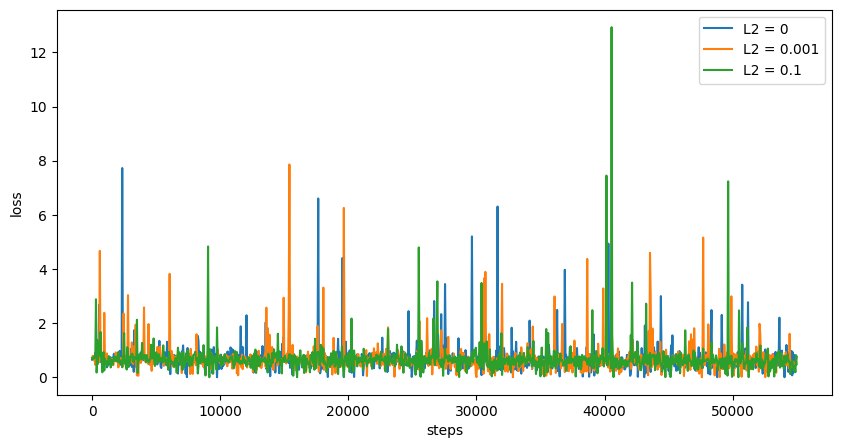

Metrics for L2 = 0
F1 Score:  0.7145020825444908
Accuracy:  0.6984
Metrics for L2 = 0.001
F1 Score:  0.7133182844243793
Accuracy:  0.6698
Metrics for L2 = 0.1
F1 Score:  0.7255694342395297
Accuracy:  0.7012


In [ ]:
# Plot Loss across different L2 regularization
plt.figure(figsize=(10, 5))
sns.lineplot(data=pandas.DataFrame(losses_def, columns=['steps', 'loss']), x="steps", y="loss", label="L2 = 0")
sns.lineplot(data=pandas.DataFrame(losses_001, columns=['steps', 'loss']), x="steps", y="loss", label="L2 = 0.001")
sns.lineplot(data=pandas.DataFrame(losses_1, columns=['steps', 'loss']), x="steps", y="loss", label="L2 = 0.1")
plt.show()

# Compute F1 score for each model
print("Metrics for L2 = 0")
evaluate(df_eval, Y_class_eval, indices, model_def)
print("Metrics for L2 = 0.001")
evaluate(df_eval, Y_class_eval, indices, model_001)
print("Metrics for L2 = 0.1")
evaluate(df_eval, Y_class_eval, indices, model_1)

### Effect of Different Optimizers

In [329]:
learning_rate = 5e-5
bce_loss = nn.BCELoss()

model_sgd = LogisticRegression(vocab_size)
optimizer_sgd = torch.optim.SGD(model_sgd.parameters(), lr=learning_rate)
# 1 full epoch with default SGD optimizer
losses_sgd = train(model_sgd, optimizer_sgd, X_tensor, Y_class, X_tensor.size()[0], 1, 50)

model_adam = LogisticRegression(vocab_size)
optimizer_adam = torch.optim.AdamW(model_adam.parameters(), lr=learning_rate)
# 1 full epoch with AdamW optmizer
losses_adam = train(model_adam, optimizer_adam, X_tensor, Y_class, X_tensor.size()[0], 1, 50)

model_rms = LogisticRegression(vocab_size)
optimizer_rms = torch.optim.RMSprop(model_rms.parameters(), lr=learning_rate)
# 1 full epoch with RMSprop optimizer
losses_rm = train(model_rms, optimizer_rms, X_tensor, Y_class, X_tensor.size()[0], 1, 50)

[0] loss: 1.1015160083770752
[50] loss: 0.7063407897949219
[100] loss: 0.6718868613243103
[150] loss: 0.43890824913978577
[200] loss: 0.06521045416593552
[250] loss: 0.5311827063560486
[300] loss: 0.566946804523468
[350] loss: 2.964655637741089
[400] loss: 0.66541987657547
[450] loss: 0.7811488509178162
[500] loss: 0.6498643755912781
[550] loss: 0.6620937585830688
[600] loss: 0.6189764738082886
[650] loss: 0.47499462962150574
[700] loss: 0.5939515829086304
[750] loss: 0.6797804832458496
[800] loss: 0.5365225076675415
[850] loss: 0.7065305113792419
[900] loss: 0.5919561386108398
[950] loss: 0.7164112329483032
[1000] loss: 0.656794011592865
[1050] loss: 0.7474075555801392
[1100] loss: 0.2769825756549835
[1150] loss: 1.321183204650879
[1200] loss: 0.5821492671966553
[1250] loss: 0.9663915634155273
[1300] loss: 1.199788212776184
[1350] loss: 2.8613979816436768
[1400] loss: 0.19977082312107086
[1450] loss: 0.7452611923217773
[1500] loss: 0.7126872539520264
[1550] loss: 0.2171085625886917
[1

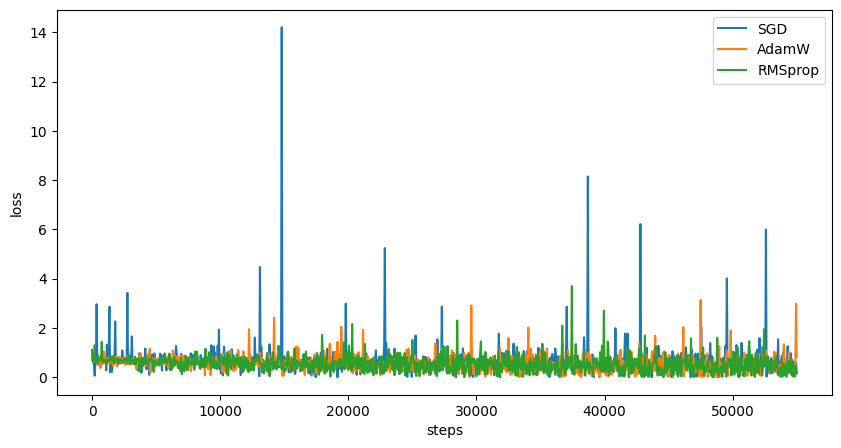

Metrics for SGD
F1 Score:  0.6968390804597702
Accuracy:  0.6624
Metrics for AdamW
F1 Score:  0.7799720726112108
Accuracy:  0.7794
Metrics for RMSprop
F1 Score:  0.7646336471551372
Accuracy:  0.77


In [330]:
# Plot Loss across different Optimizers
plt.figure(figsize=(10, 5))
sns.lineplot(data=pandas.DataFrame(losses_sgd, columns=['steps', 'loss']), x="steps", y="loss", label="SGD")
sns.lineplot(data=pandas.DataFrame(losses_adam, columns=['steps', 'loss']), x="steps", y="loss", label="AdamW")
sns.lineplot(data=pandas.DataFrame(losses_rm, columns=['steps', 'loss']), x="steps", y="loss", label="RMSprop")
plt.show()

# Compute F1 score for each model
print("Metrics for SGD")
evaluate(df_eval, Y_class_eval, indices, model_sgd)
print("Metrics for AdamW")
evaluate(df_eval, Y_class_eval, indices, model_adam)
print("Metrics for RMSprop")
evaluate(df_eval, Y_class_eval, indices, model_rms)

### Effect of Different Tokenizers

In [ ]:
learning_rate = 5e-5
bce_loss = nn.BCELoss()

model_better_tokenizer = LogisticRegression(vocab_size)
optimizer_better_tokenizer = torch.optim.SGD(model_better_tokenizer.parameters(), lr=learning_rate)
# 1 full epoch with better tokenizer
losses_better_tokenizer = train(model_better_tokenizer, optimizer_better_tokenizer, X_tensor, Y_class, X_tensor.size()[0], 1, 50)

# create a sparse matrix for all training documents using basic tokenizer
matrix_basic_tokenize, indices_basic_tokenize = create_sparse_matrix(df["generation"], tokenize)
X_tensor_basic = to_sparse_tensor(matrix_basic_tokenize)

model_basic_tokenizer = LogisticRegression(vocab_size)
optimizer_basic_tokenizer = torch.optim.SGD(model_basic_tokenizer.parameters(), lr=learning_rate)
# 1 full epoch with better tokenizer
losses_basic_tokenizer = train(model_basic_tokenizer, optimizer_basic_tokenizer, X_tensor_basic, Y_class, X_tensor_basic.size()[0], 1, 50)

In [ ]:
print(X_tensor_basic.size())

In [ ]:
# Plot Loss across different Tokenizers
plt.figure(figsize=(10, 5))
sns.lineplot(data=pandas.DataFrame(losses_better_tokenizer, columns=['steps', 'loss']), x="steps", y="loss", label="better tokenizer")
sns.lineplot(data=pandas.DataFrame(losses_basic_tokenizer, columns=['steps', 'loss']), x="steps", y="loss", label="basic tokenizer")
plt.show()

# Compute F1 score for each model
print("Metrics for Better Tokenizer")
evaluate(df_eval, Y_class_eval, indices, model_better_tokenizer)
print("Metrics for Basic Tokenizer")
evaluate(df_eval, Y_class_eval, indices, model_basic_tokenizer, tokenize)
